## In this assignment, we use photos from Large-scale CelebFaces Attributes (CelebA) Dataset to train convets that can classify photos to male celebrities and female celebrities accurately.
## To make this problem more challenging, we only use 2,000 photos for training, 1,000 photos for validation, and 1,000 photos for testing.
## For the first part of the assignment, following the example of chapter 5.2. Here we train our model using only the 2,000 training photos. Note you need to use data augmentation and dropout to fight overfiting. Warning: one of the training step took about 9 hours on my computer.
## For the second part, we use a pretrained convet (VGG16) to help with our task. Do the fast feature extraction without augmentation. And do the fine-tuning following chapter 5.3.2. Warning: this part took about 11 hours on my computer.  To speed our the computation, I used the following setting. 
history = model.fit_generator(
      train_generator,
      steps_per_epoch=25,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=25)
## Compare this setting to the textbook and you will see what I changed. If you do not have enough time, you can reduce the number of epochs. This way, you may not get the best result, but you can convince the grader that you know how to solve the problem.
## Important information before you start: all the photos are of the size (218, 178), where height = 218, and width = 178.

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
import os, shutil

In [3]:
base_dir = '/home/keshav/ML_proj/working_dir/ml_working_dir/PA5/p5/programming5'

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training male pictures
train_male_dir = os.path.join(train_dir, 'male')

# Directory with our training female pictures
train_female_dir = os.path.join(train_dir, 'female')

# Directory with our validation male pictures
validation_male_dir = os.path.join(validation_dir, 'male')

# Directory with our validation female pictures
validation_female_dir = os.path.join(validation_dir, 'female')

# Directory with our validation male pictures
test_male_dir = os.path.join(test_dir, 'male')

# Directory with our validation female pictures
test_female_dir = os.path.join(test_dir, 'female')

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [4]:
print('total training male images:', len(os.listdir(train_male_dir)))

total training male images: 825


In [5]:
print('total training female images:', len(os.listdir(train_female_dir)))

total training female images: 1175


In [6]:
print('total validation male images:', len(os.listdir(validation_male_dir)))

total validation male images: 413


In [7]:
print('total validation female images:', len(os.listdir(validation_female_dir)))

total validation female images: 587


In [8]:
print('total test male images:', len(os.listdir(test_male_dir)))

total test male images: 412


In [9]:
print('total test female images:', len(os.listdir(test_female_dir)))

total test female images: 588


# Part 1 

In this case we're going to be training for male and female. I'll train with dropout and augmentation. At the end I'll plot the accuracy on the validation set. 

Note that I pickle my notebook enviornment and that way I don't have to worry about my data getting messed up in the event that I want to store my session. I also traditionally save my model. 

In [10]:
#This is a configuration cell. It has all the config options I should need. 
from keras.models import Sequential as SQ
from keras.layers import Conv2D as C2D, MaxPooling2D as MP2D, Flatten as F, Dropout as Drp, Dense as Dns
from keras.preprocessing.image import ImageDataGenerator as IDG
import numpy as np
import matplotlib.pyplot as plt
import dill
INPUT_DATA_SHAPE = (218, 178)
random_seed = 42
np.random.seed(random_seed)
%matplotlib inline

In [11]:
def build_generator(gen_dirs, no_labels=False):
    if no_labels:
        return IDG(rescale=1./255).flow_from_directory(gen_dirs,
                                       class_mode=None,
                                       target_size=INPUT_DATA_SHAPE, 
                                       color_mode='rgb',
                                       batch_size=32, 
                                       shuffle=True, 
                                       seed=random_seed,
                                      interpolation='nearest')
    return IDG(rescale=1./255,
               rotation_range=33, 
               width_shift_range=0.1, 
               height_shift_range=.4, 
               brightness_range=(0., 10.), 
               shear_range=20.0, 
               zoom_range=.3, 
               channel_shift_range=0.0, 
               fill_mode='nearest', 
               horizontal_flip=True, 
               vertical_flip=True).flow_from_directory(gen_dirs, 
                                      target_size=INPUT_DATA_SHAPE, 
                                      color_mode='rgb',  
                                      class_mode='binary', 
                                      batch_size=32, 
                                      shuffle=True, 
                                      seed=random_seed,
                                      interpolation='nearest')

In [12]:
train_gen = build_generator(train_dir)
val_gen = build_generator(validation_dir)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Found 2000 images belonging to 2 classes.
(32, 218, 178, 3)
(32,)
1.0
[1. 1. 1.]
3


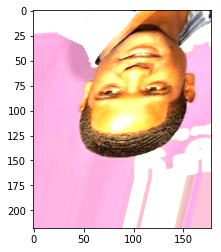

In [13]:
#temp gen for insurance reasons
train_gen_t = build_generator(train_dir)

#Grab an iteration
img_batch, labels = next(train_gen_t)

#Print our two shapes
print(img_batch.shape)
print(labels.shape)


print(labels[0]) #Print the label so we can discover what defines a man vs woman
print(img_batch[0, 0, 0]) #Print one px of data 
print(len(img_batch[0][0][0])) #Print the len of the last row. If 3 we're chan last.
plt.imshow(img_batch[0]) #Display the whole first image
del img_batch, labels, train_gen_t #Delete our temp vals that were made for insurance

#### After running this a couple of times, it looks like we have male pictures coming in as 1, and females coming in as 0.

I'm just noting that for future refrence.

Looks like our data augmentation is also working. (Or whoever took that picture is a really terrible photographer)

In [14]:
s_params = {
    "activation":"relu",
    "ks": 3,
    "mp":(2, 2)
}

image_model = SQ()

image_model.add(C2D(2**5,
                    s_params["ks"], 
                    input_shape=(INPUT_DATA_SHAPE[0], INPUT_DATA_SHAPE[1], 3),
                    padding="valid",
                    activation=s_params["activation"]))
                    
image_model.add(MP2D(s_params["mp"]))
image_model.add(C2D(2**6, s_params["ks"], activation=s_params["activation"]))
image_model.add(MP2D(s_params["mp"]))
image_model.add(C2D(2**7, s_params["ks"], activation=s_params["activation"]))
image_model.add(MP2D(s_params["mp"]))
image_model.add(C2D(2**8, s_params["ks"], activation=s_params["activation"]))
image_model.add(MP2D(s_params["mp"]))
image_model.add(C2D(2**9, s_params["ks"], activation=s_params["activation"]))
image_model.add(MP2D(s_params["mp"]))
image_model.add(F()) #Flatten
image_model.add(Drp(.3)) #dropout layer

In [15]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 216, 176, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 108, 88, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 106, 86, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 43, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 51, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 20, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 18, 256)       295168    
__________

### Now we know our shapes, we can stack a classifier on, and begin training. 

In [16]:
image_model.add(Dns(6144, activation=s_params["activation"])) #dense layer
image_model.add(Dns(int(6144/2), activation=s_params["activation"])) #dense layer
image_model.add(Dns(1, activation="sigmoid")) #sigmoid activation dense 

In [17]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 216, 176, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 108, 88, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 106, 86, 64)       18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 43, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 51, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 20, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 18, 256)       295168    
__________

This is the final model. 

Many params. But it should be okay


In [18]:
from keras.optimizers import RMSprop
image_model.compile(optimizer=RMSprop(lr=.0001),
                    loss="binary_crossentropy",
                    metrics=["acc"])

In [19]:
train_stat = image_model.fit_generator(train_gen, steps_per_epoch=100, epochs=100, validation_data=val_gen, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 426s 4s/step - loss: 0.6863 - acc: 0.5753 - val_loss: 0.7056 - val_acc: 0.5787
Epoch 2/100
100/100 [==============================] - 418s 4s/step - loss: 0.6807 - acc: 0.5872 - val_loss: 0.6650 - val_acc: 0.6140
Epoch 3/100
100/100 [==============================] - 419s 4s/step - loss: 0.6684 - acc: 0.6009 - val_loss: 0.6592 - val_acc: 0.6212
Epoch 4/100
100/100 [==============================] - 415s 4s/step - loss: 0.6612 - acc: 0.6013 - val_loss: 0.6684 - val_acc: 0.6031
Epoch 5/100
100/100 [==============================] - 417s 4s/step - loss: 0.6575 - acc: 0.6053 - val_loss: 0.6471 - val_acc: 0.6421
Epoch 6/100
100/100 [==============================] - 418s 4s/step - loss: 0.6537 - acc: 0.6081 - val_loss: 0.6461 - val_acc: 0.6360
Epoch 7/100
100/100 [==============================] - 418s 4s/step - loss: 0.6541 - acc: 0.6116 - val_loss: 0.6436 - val_acc: 0.6567
Epoch 8/100
100/100 [==============================] - 419s 4s

Epoch 62/100
100/100 [==============================] - 417s 4s/step - loss: 0.5199 - acc: 0.7278 - val_loss: 0.4884 - val_acc: 0.7405
Epoch 63/100
100/100 [==============================] - 418s 4s/step - loss: 0.5087 - acc: 0.7350 - val_loss: 0.5208 - val_acc: 0.7390
Epoch 64/100
100/100 [==============================] - 415s 4s/step - loss: 0.5186 - acc: 0.7322 - val_loss: 0.5061 - val_acc: 0.7397
Epoch 65/100
100/100 [==============================] - 419s 4s/step - loss: 0.5136 - acc: 0.7325 - val_loss: 0.4985 - val_acc: 0.7437
Epoch 66/100
100/100 [==============================] - 419s 4s/step - loss: 0.5074 - acc: 0.7409 - val_loss: 0.5043 - val_acc: 0.7390
Epoch 67/100
100/100 [==============================] - 417s 4s/step - loss: 0.5185 - acc: 0.7397 - val_loss: 0.5020 - val_acc: 0.7519
Epoch 68/100
100/100 [==============================] - 418s 4s/step - loss: 0.5130 - acc: 0.7466 - val_loss: 0.5315 - val_acc: 0.7287
Epoch 69/100
100/100 [==============================] -

In [20]:
image_model.save('img_model_big.h5')

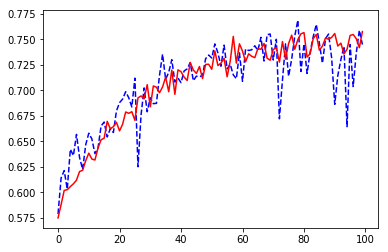

In [22]:
plt.plot(train_stat.history["val_acc"], 'b--')
plt.plot(train_stat.history["acc"], 'r-')


Looking at the curve, we have accuracy and validation accuracy. The fact that the curves lie basically right on top of one another demonstrate the fact that this model isn't over fitting. It can also be seen that we hit a kind of platau around the 60 epoch mark. I want to look at this area in a bit more detail, in comparison to an area where there's a clear rise in accuracy. 


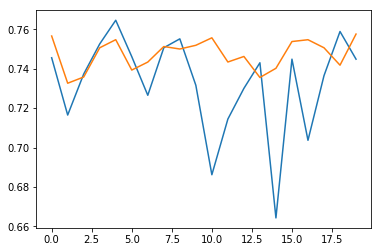

In [26]:
plt.plot(train_stat.history["val_acc"][80:])
plt.plot(train_stat.history["acc"][80:])

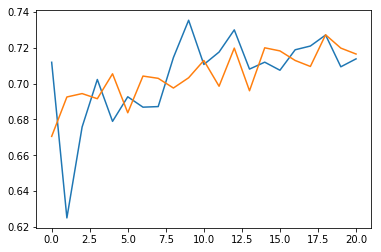

In [27]:
plt.plot(train_stat.history["val_acc"][25:46])
plt.plot(train_stat.history["acc"][25:46])

In [29]:
del train_gen, val_gen
dill.dump_session("celeb_workspace")


It seems that the first version of the network got an accuracy of about .74 on the val. I'll test it on the test set now.

Then I'll move on to part 2

In [31]:
test_gen = build_generator(test_dir)
image_model_test_stats = image_model.evaluate_generator(test_gen, steps=50, max_queue_size=10,  verbose=3)

Found 1000 images belonging to 2 classes.


In [34]:
print(image_model.metrics_names)
print(image_model_test_stats)

['loss', 'acc']
[0.5156648932072112, 0.7195431472081218]


It seems that we're looking at about 72% accuracy with the data that we have available.


I'll be doing part two (Fine tuning + using pre-built models) in a sperate file. 